## Monte Carlo Control

In [1]:
import sys
sys.path.append("..")
from scripts.k_armbed_bandit.functions import moving_average

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# for visualization of animation
from PIL import Image
from matplotlib import animation
from IPython.display import HTML

# RL gymnasium
import gymnasium as gym
from gymnasium import spaces
import pygame

from copy import deepcopy
import warnings
warnings.filterwarnings("ignore")

In [2]:
class Race(gym.Env):
    def __init__(self, 
                 race_track, # race track grid - 0 for track, 1 for start, 2 for goal, 3 for barrier
                 velocity_cap, # max absolute value
                 time_limit,
                ):

        # entire race track
        self.race_track = race_track

        # get track
        self.track = np.argwhere(self.race_track == 0)
        self.track = [tuple(i) for i in self.track]        

        # get starting points
        self.start_coords = np.argwhere(self.race_track == 1)
        self.start_coords = [tuple(i) for i in self.start_coords]
        
        # get end points
        self.end_coords = np.argwhere(self.race_track == 2)
        self.end_coords = [tuple(i) for i in self.end_coords]

        # get barriers
        self.barriers = np.argwhere(self.race_track == 3)
        self.barriers = [tuple(i) for i in self.barriers]

        # velocity cap
        self.velocity_cap = velocity_cap

        # time limit
        self.time_limit = time_limit
        self.num_timestemps = 0

        # We have 9 actions, for velocity changes (-1, 0, +1) for each (x, y)
        self.action_space = spaces.Discrete(9)

        """
        The following dictionary maps abstract actions from `self.action_space` to
        """

        self._action_to_velocity_delta = {
                    0: (0, 0), # (y, x) velocity changes since (row-wise, column-wise)
                    1: (0, 1),
                    2: (0, -1),
                    3: (1, 0),
                    4: (-1, 0),
                    5: (1, -1),
                    6: (-1, 1),
                    7: (-1, -1),
                    8: (1, 1),
                }
        
        # back to start at the very beginning and initialize velocity
        self._back_to_start()

    def _get_obs(self):
        return {"agent": self._agent_location}

    def _get_info(self):
        return {"velocity": self._agent_velocity,
                "next_state": self._agent_next_location, # predicted next location
                }
    
    # place agent back to start (if barrier is hit) or env is reset
    def _back_to_start(self):
        # Choose the agent's location uniformly at random
        j = np.random.choice(range(len(self.start_coords)))
        self._agent_location = self.start_coords[j] # random location on any of the start of the track

        # agent velocity is 
        self._agent_velocity = [0, 0] # reset to 0
        self._agent_next_location = self._agent_location # initialize next location

    def reset(self, seed=None, options=None):

        # We need the following line to seed self.np_random
        # this resets the environment?
        super().reset(seed=seed)
        
        self._back_to_start()
        observation = self._get_obs()
        info = self._get_info()
        self.num_timestemps = 0 # reset timesteps

        return observation, info
    
    def step(self, action):
        # Map the action (element of {0,1,2,3...}) to the velocity
        self.velocity_delta = self._action_to_velocity_delta[action]

        # update velocity
        self._agent_velocity[0] = self._agent_velocity[0] + self.velocity_delta[0]
        self._agent_velocity[1] = self._agent_velocity[1] + self.velocity_delta[1]

        # clip velocity so it is never negative? # THIS IS SUTTON'S PROBLEM !!!
        # but maybe we can skip this for now to make it more versatile!!
        # Cap velocity to have absolute value of <= velocity_cap
        self._agent_velocity[0] = np.clip(self._agent_velocity[0],
                                       -self.velocity_cap, self.velocity_cap)
        self._agent_velocity[1] = np.clip(self._agent_velocity[1],
                                       -self.velocity_cap, self.velocity_cap)  

        # velocity must not be (0, 0)
        if tuple(self._agent_velocity) == (0, 0):
            action = np.random.choice(range(1, 9)) # excluding 0
            self._agent_velocity = np.array(self._action_to_velocity_delta[action]) # just get a random action

        # anticipate the next location --  THIS IS WHAT WE USE FOR REWARD COMPUTATION
        self._agent_next_location = [self._agent_location[0] + self._agent_velocity[0], 
                                     self._agent_location[1] + self._agent_velocity[1]]        

        # note not yet terminated
        terminated = False

        # if next location is outside the track, then go back to start!! -- NOPE. JUST STAY IN POSITION BUT MAKE PENALTY = -10
        if tuple(self._agent_next_location) in self.barriers:
            # self._back_to_start() # back to start if hit barriers?

            # if hit barrier, make the velocity 0 again and randomize delta velocity
            action = np.random.choice(range(1, 9)) # excluding 0
            self._agent_velocity = np.array(self._action_to_velocity_delta[action]) # just get a random action            

            # large penalty
            reward = -10

        # if next location is in the Finish Area then awesome -- just make the finish area large
        elif tuple(self._agent_next_location) in self.end_coords:
            self._agent_location = self._agent_next_location
            terminated = True
            reward = -1

        # otherwise update location
        else:
            self._agent_location = self._agent_next_location
            reward = -1

        # An episode is done iff the agent has reached the target - in the Finish area
        observation = self._get_obs()
        info = self._get_info()

        self.num_timestemps += 1

        if self.num_timestemps > self.time_limit:
            truncated = True
        else:
            truncated = False

        return observation, reward, terminated, truncated, info
    
    def render(self):
        race_track_viz = deepcopy(self.race_track)
        race_track_viz[self._agent_location[0], self._agent_location[1]] = 4

        return race_track_viz

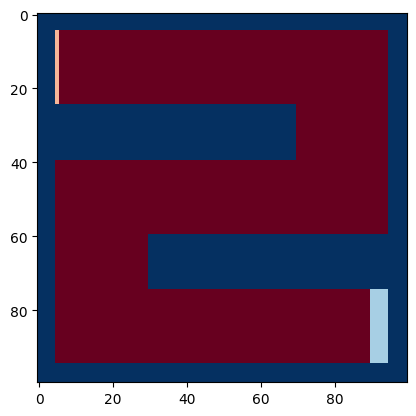

In [54]:
h = 100
w = 100
racecar_track = np.ones((h, w)) * 3

# horizontal
racecar_track[75:-5, 5:-5] = 0
racecar_track[40:60, 5:-5] = 0
racecar_track[5:25, 5:-5] = 0

# vertical
racecar_track[-40:, 5:30] = 0
racecar_track[:-40, 70:-5] = 0
# racecar_track[5:-5, 45:55] = 0

racecar_track[:5, :] = 3
racecar_track[-5:, :] = 3

# for j in j_start:
racecar_track[5:25, 5] = 1
racecar_track[-25:-5, -10:-5] = 2

plt.imshow(racecar_track, cmap='RdBu')

3481


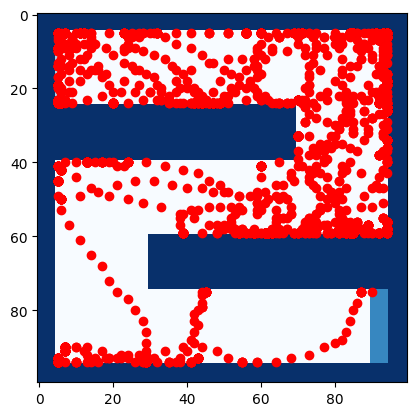

In [55]:
env = Race(race_track=racecar_track, velocity_cap=5, time_limit=20000)
env.reset()

agent_locs = []
terminated = False
truncated = False
while not truncated and not terminated:
    a = np.random.choice(range(9))
    observation, reward, terminated, truncated, info = env.step(a)
    if truncated:
        env.reset()
    agent_locs += [env._agent_location]

# MC Control
print(len(agent_locs))
agent_locs = np.array(agent_locs)
plt.imshow(racecar_track, cmap='Blues')
plt.scatter(agent_locs[:, 1], agent_locs[:, 0], c='r', marker='o')

In [56]:
class MC:
    def __init__(self, env, Q_init_val):
        self.env = env
        self.Q, self.state_map = self.init_Q_C(init_val=Q_init_val)
        self.C, _ = self.init_Q_C(init_val=0)
    
    def init_Q_C(self, init_val):

        actions_list = list(self.env._action_to_velocity_delta.values())
        states = self.env.track + self.env.start_coords # + self.env.end_coords

        state_map = {}

        Q = np.ones(shape=(len(states), len(actions_list)))
        for s in range(len(states)):
            for a in range(len(actions_list)):
                if init_val == 'normal':
                    Q[s, a] = np.random.normal()
                else:
                    Q[s, a] = init_val # optimistic starts

                state_map[states[s]] = s

        self.actions_list = actions_list

        return Q, state_map

    def pi(self, s, eps):

        s_idx = self.state_map[s]
        assert type(s_idx) == int

        explore = np.random.choice([True, False], p=[eps, 1-eps])

        if explore:
            a = np.random.choice(range(self.Q.shape[1]))

        else:
            # greedy. randomly break ties
            a = np.random.choice(np.argwhere(self.Q[s_idx, :] == max(self.Q[s_idx, :])).flatten())

        return a
    
    def generate_trajectory(self, eps, get_last_state=False):

        self.env.reset()

        S = []
        A = []
        R = []
        while True:

            observation = self.env._get_obs()['agent'] # initial observation
            observation = tuple(observation)    

            a = self.pi(observation, eps=eps)
            A += [a]
            S += [observation]

            observation, reward, terminated, truncated, info = self.env.step(a)
            observation = tuple(observation['agent'])

            R += [reward]
            if terminated or truncated: # run until either terminated or truncated!
                if get_last_state:
                    S += [observation] # for visualization purposes ONLY! NOT FOR TRAINING!
                    assert len(S) - 1 == len(A) == len(R)
                else:
                    assert len(S) == len(A) == len(R)
                self.env.reset()
                break
        
        return S, A, R, terminated, truncated


    def learn(self, n_iters, eps_b, eps_pi, gamma):

        # compute b(A|S) for greedy action for behavior policy
        proba_greedy_b = 1 - eps_b + eps_b/len(self.actions_list)
        proba_nongreedy_b = eps_b/len(self.actions_list)

        # compute b(A|S) for greedy action for target policy
        proba_greedy_pi = 1 - eps_pi + eps_pi/len(self.actions_list)
        proba_nongreedy_pi = eps_pi/len(self.actions_list)

        # greedy pi defined above
        # loop over many episodes, i = episode
        for i in range(n_iters):
            # b = lambda: epsilon-greedy defined above, b(A|S)
            # generate episode using b -> S, A, R which are sequences from 0 to T-1 (for S, A) or T (for R)

            # make sure terminated
            terminated = False

            # run until we get a terminated episode
            while not terminated:
                S, A, R, terminated, truncated = self.generate_trajectory(eps_b) # follows epsilon-greedy for behavior policy 

            # convert S to indices for Q and C
            S_idx = [self.state_map[s] for s in S]

            G = 0 # init returns for each episode
            W = 1 # initi sampling ratio, weighted, for each episode
            num_steps = len(S) # num steps in episode

            # run episode until termination
            for t in range(num_steps)[::-1]: # reversed from T-1 ... 0

                G = G * gamma + R[t] # this R[t] corresponds to R_{t+1}, yeah confusing I know

                # C - we basically sum up because of weighted importance sampling, 
                # if ordinary sampling then C is basically the number of times St has been visited aka C += 1
                self.C[S_idx[t], A[t]] = self.C[S_idx[t], A[t]] + W

                # the G - Q is the incremental update rule!
                self.Q[S_idx[t], A[t]] = self.Q[S_idx[t], A[t]] + (W / self.C[S_idx[t], A[t]]) * (G - self.Q[S_idx[t], A[t]])
                
                # only select those A ~ b that are A ~ target pi for greedy
                A_max_list = np.argwhere(self.Q[S_idx[t], :] == max(self.Q[S_idx[t], :])).flatten()  
                
                # if eps_pi == 0:
                if A[t] not in A_max_list:
                    break # break inner loop. we cant compute since here, proba_greedy_pi = 0

                else:
                    # W = W * 1 / b[A[t], S[t]] # probability of greedy action eps=0 is 1
                    W = W * proba_greedy_pi / proba_greedy_b # here proba_greedy_pi = 1

                # elif eps_pi > 0: 
                #     if A[t] not in A_max_list:
                #         # not greedy behavior policy, b
                #         W = W * proba_greedy_pi / proba_nongreedy_b

                #     else:
                #         # greedy behavior policy
                #         W = W * proba_greedy_pi / proba_greedy_b

                # print(np.around(W, 1))

In [57]:
# for checkpoint tracking
ckp_idx = 0
agent_checkpoints = {}

# count number of steps
steps_tracker = []

# hyperparam
Q_init_val = -100 # EXPERIMENT ON THIS VALUE

# initialize agent
agent = MC(env, Q_init_val)
agent.env.reset()

({'agent': (10, 5)}, {'velocity': [0, 0], 'next_state': (10, 5)})

In [58]:
# EXPERIMENT ON THESE VALUES
# Off-policy MC Control algorithm with weighted sampling
eps_b = 0.1
eps_pi = 0
gamma = 0.99

In [87]:
for i in range(1000):
    n_iters = 100
    agent.learn(n_iters, eps_b, eps_pi, gamma)

    ckp_idx += n_iters
    agent_checkpoints[ckp_idx] = deepcopy(agent)

    print(ckp_idx)
    # print(Counter(agent.Q.flatten()))

1400
1500
1600
1700
1800
1900


KeyboardInterrupt: 

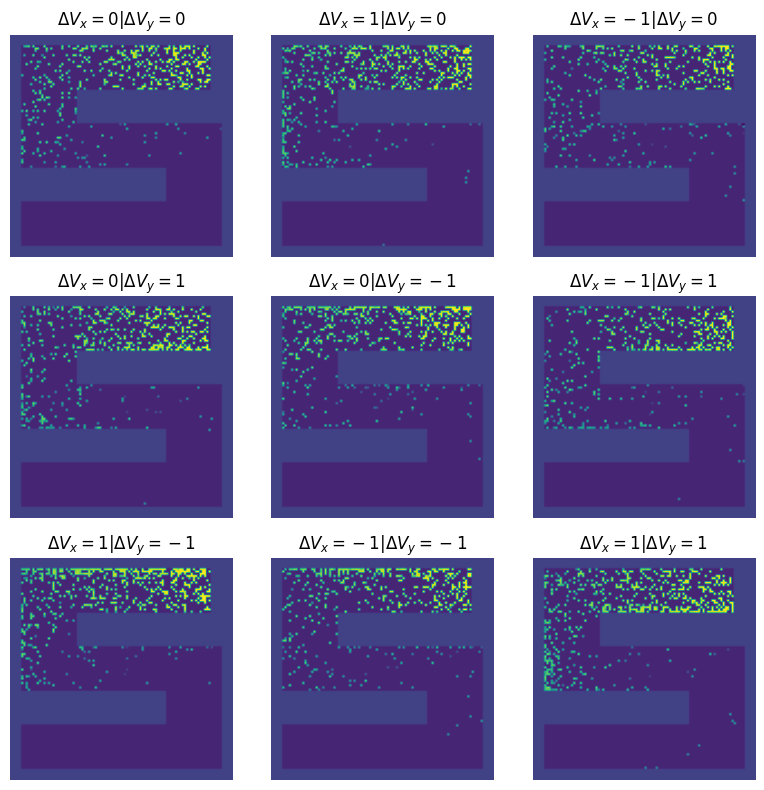

In [88]:
# visualize and animate how Q changes over time
def visualize_q(iter):
    
    ckp_idx = iter * 100
    agent_ = agent_checkpoints[ckp_idx]


    fig, axs = plt.subplots(3, 3, figsize=(8, 8), sharex=True, sharey=True)
    axs = axs.flatten()

    _min = agent_.Q.min()
    _max = agent_.Q.max()

    for a, ax in zip(range(len(agent_.env._action_to_velocity_delta)), axs):
        q_a =agent_.Q[:, a]
        q_sa_map = {k:v for k, v in enumerate(q_a)}
        rev_state_map = {v:k for k, v in agent_.state_map.items()}

        Q_map = np.ones(shape=agent_.env.race_track.shape) * (Q_init_val + 10)
        for i in range(agent_.Q.shape[0]):
            coord = rev_state_map[i]
            Q_map[coord] = q_sa_map[i]

        ax.imshow(Q_map, cmap='viridis', vmin = _min, vmax = _max)
        ax.set_axis_off()
        ax.invert_yaxis()
        ax.set_title(f"$\Delta V_x = {agent_.env._action_to_velocity_delta[a][1]} | \Delta V_y = {agent_.env._action_to_velocity_delta[a][0]}$")
    plt.tight_layout()

visualize_q(19)

In [ ]:
# ANIMATE HOW THE TRAJECTORIES CHANGE OVER LEARNING ITERATIONS! - 5 RANDOM SAMPLES PER ITER

In [ ]:
# VISUALIZE EPISODE TIMESTEPS LENGTH VS LEARNING ITERATIONS

792


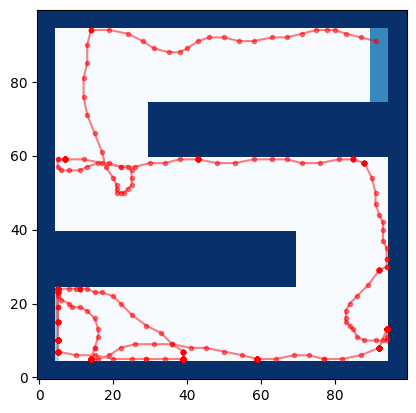

In [89]:
latest_ckp = max(agent_checkpoints.keys())
latest_ckp

agent_test = agent_checkpoints[latest_ckp]
S, A, R, truncated, terminated = agent_test.generate_trajectory(eps=eps_pi, get_last_state=True)
print(len(S))

agent_locs = np.array(S)
plt.imshow(racecar_track, cmap='Blues')
plt.plot(agent_locs[:, 1], agent_locs[:, 0], c='r', marker='.', alpha=0.5)
plt.gca().invert_yaxis()
plt.show()

In [90]:
def animate(iter):
    global agent_locs, racecar_track
    ax.clear()
    ax.imshow(racecar_track, cmap='Blues')
    ax.scatter(agent_locs[iter, 1], agent_locs[iter, 0], c='r', marker='o', s=150)  
    ax.set_axis_off()  
    ax.invert_yaxis()
    plt.tight_layout()

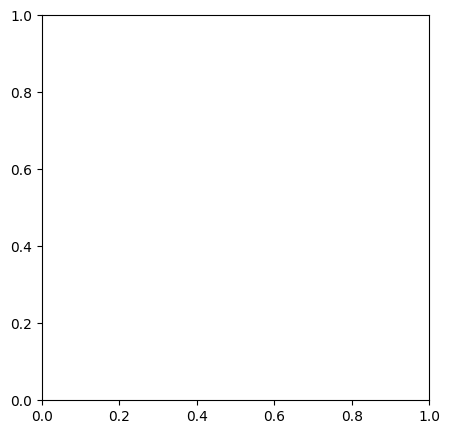

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

In [92]:
agent_locs = np.array(S)[-500:] # visualize last 500 frames
anim = animation.FuncAnimation(fig,
                               animate,
                               frames=len(agent_locs), 
                               interval=1)
HTML(anim.to_jshtml(fps=30))

<Figure size 640x480 with 0 Axes>

In [71]:
# DO A RACE OF DIFFERENT MODELS -- HYPERPARAMS